# Project Setup

The following section installs the TensorFlow library for Python.

In [ ]:
!pip install tensorflow
!pip install -q -U keras_tuner~=1.4.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


This section imports and sets up the necessary libraries. It also sets the random seeds of the libraries so the results in each run are consistent.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import logging
import random
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

tf.get_logger().setLevel(logging.ERROR)

# Get the Data

Here, the training and testing datasets are imported and processed for use in the models. The datatset being imported is the Fashion MNIST, which contains images depicting 10 types of clothing items: t-shirts, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots.

In [ ]:
#Loading the training and test data
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's also make an array that we can use to map label numbers to actual strings. This will help us identify samples later on.

In [ ]:
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Now that we have the data, let's take a look at its structure.

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
train_labels.shape

(60000,)

In [ ]:
test_images.shape

(10000, 28, 28)

In [ ]:
test_labels.shape

(10000,)

It looks like we have 28x28p grayscale images, each associated with singular labels. Let's print out a sample with the label.

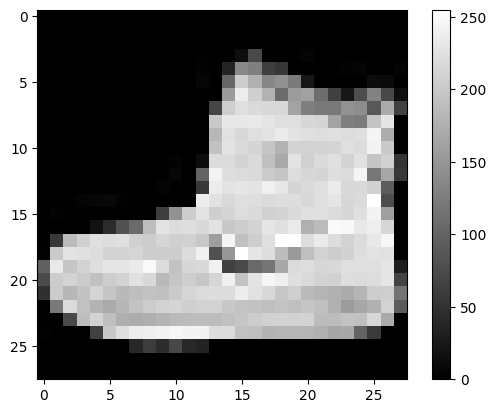

In [ ]:
plt.imshow (train_images[0], cmap='gray')
plt.colorbar ()
plt.show ()

In [ ]:
print (train_labels[0], label_names[train_labels[0]])

9 Ankle boot


Now let's check how common each label is. If the data is unbalanced, it could affect the accuracy of our model after training.

In [ ]:
print ("=====Training Label Value Counts=====")
pd.Series(train_labels).sort_values().value_counts()

=====Training Label Value Counts=====


,count
0,6000
1,6000
2,6000
3,6000
4,6000
5,6000
6,6000
7,6000
8,6000
9,6000


In [ ]:
print ("=====Test Label Value Counts=====")
pd.Series(test_labels).sort_values().value_counts()

=====Test Label Value Counts=====


,count
0,1000
1,1000
2,1000
3,1000
4,1000
5,1000
6,1000
7,1000
8,1000
9,1000


It looks like both the train and test sets are perfectly balanced, which means stratified sampling won't be needed.

# Prepare the Data

Now that we have the dataset loaded, let's create an algorithm to prepare it for training. Preparing the data will increase our model's accuracy. The best thing we can do is to standardize the data so it uses a range of values better suited for our model and its activation functions.

In [ ]:
mean = np.mean(train_images)
std = np.std(train_images)

train_images = (train_images - mean) / std
test_images = (test_images - mean) / std

Next, we should convert the labels using one-hot encoding so the model understands that the labels are categorical and doesn't assume that the order of the labels is important.

In [ ]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

# Model Definition

Now that the data is ready, we can define our model. We wil base its design on the example model for the MNIST digits dataset shown in the lectures. It start with two convolution and max pooling layer pairs, followed by a flattening layer. After that, it will have one fully connected layer and an output layer with 10 output neurons (one for each class). We will also define some hyperparameters based on the best model configurations from Assignment 4.

In [ ]:
model = keras.Sequential([
    # Model input
    keras.layers.Input(shape=(28,28,1)),

    # Convolutional part of the model
    keras.layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_initializer='he_normal', bias_initializer = 'zeros'),
    keras.layers.MaxPooling2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_initializer='he_normal', bias_initializer = 'zeros'),
    keras.layers.MaxPooling2D(pool_size=(1,1), strides=(2,2)),

    # Fully connected part of the model
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='tanh', kernel_initializer='he_normal', bias_initializer = 'zeros'),
    keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer = 'zeros')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'auc'])

In [ ]:
model.summary ()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

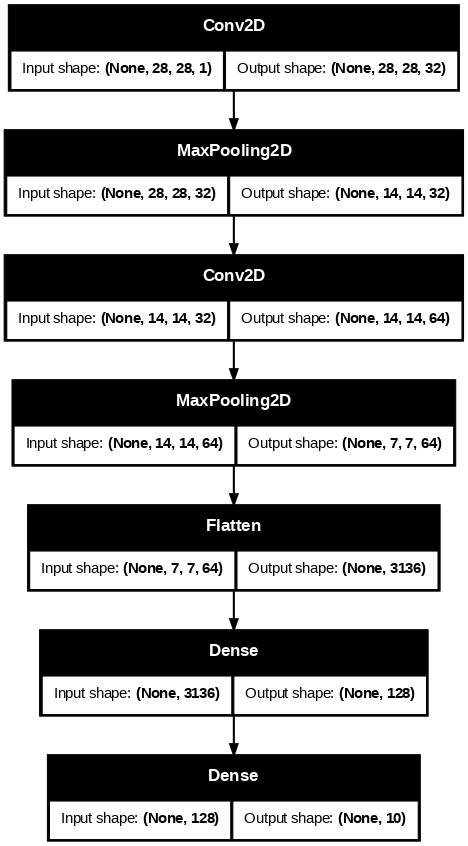

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=75)

# Model Training and Evaluation

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
history = model.fit(
    train_images,
    train_labels,
    validation_split = 0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    shuffle=True
  )

Epoch 1/10
375/375 - 11s - 30ms/step - accuracy: 0.8396 - auc: 0.9874 - loss: 0.4532 - precision: 0.8854 - recall: 0.8006 - val_accuracy: 0.8677 - val_auc: 0.9922 - val_loss: 0.3517 - val_precision: 0.8926 - val_recall: 0.8476
Epoch 2/10
375/375 - 2s - 6ms/step - accuracy: 0.8954 - auc: 0.9946 - loss: 0.2860 - precision: 0.9144 - recall: 0.8789 - val_accuracy: 0.8822 - val_auc: 0.9930 - val_loss: 0.3225 - val_precision: 0.9010 - val_recall: 0.8668
Epoch 3/10
375/375 - 2s - 5ms/step - accuracy: 0.9165 - auc: 0.9964 - loss: 0.2277 - precision: 0.9312 - recall: 0.9042 - val_accuracy: 0.8828 - val_auc: 0.9926 - val_loss: 0.3193 - val_precision: 0.8970 - val_recall: 0.8714
Epoch 4/10
375/375 - 2s - 5ms/step - accuracy: 0.9343 - auc: 0.9976 - loss: 0.1842 - precision: 0.9448 - recall: 0.9240 - val_accuracy: 0.8863 - val_auc: 0.9922 - val_loss: 0.3236 - val_precision: 0.8983 - val_recall: 0.8755
Epoch 5/10
375/375 - 2s - 6ms/step - accuracy: 0.9478 - auc: 0.9984 - loss: 0.1510 - precision: 0.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


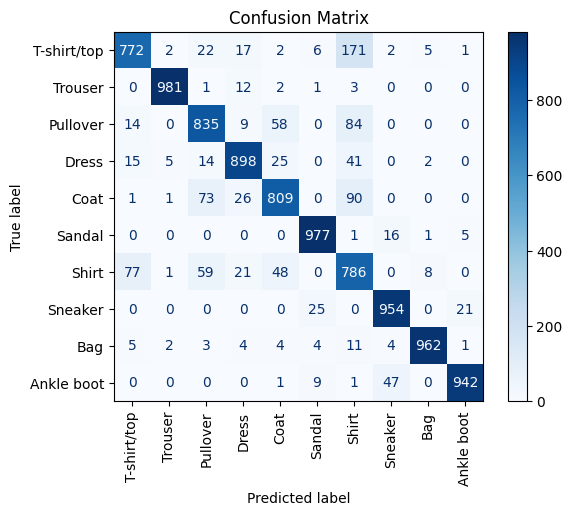

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the classes for the test set
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=label_names)

# Remove the 'normalize' parameter and use 'include_values' instead to ensure compatibility
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

The accuracy of the model is impressive, although the confusion matrix reveals some issues with the shirt label. It seems like the model confuses shirts and t-shirt/tops the most, which makes sense since they are very similar. Coats and pullovers are also in a similar situation to a less degree, where the model often confuses one for the other.

# Hyperparameter Tuning and Dynamic Model Creation

Although our current model is good, we can use the Keras Tuner to dynamically generate models under it finds one with better performance. First, we must define a function for creating new models. This will allow the tuner to change aspects of the model, such as the activation functions, learning rate, number of layers, and number of neurons.

In [ ]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class dynamic_model (kt.HyperModel):
  def build (self, hp):
    tf.keras.backend.clear_session()

    # Hyperparameters
    conv_activation = hp.Choice("conv_activation", values=["relu", "tanh", "leaky_relu"])
    optimizer_name = hp.Choice("optimizer", values=["sgd", "adam", "rmsprop"])

    conv1_filters = hp.Int("conv1_filters", min_value=16, max_value=64, step=16, default=32)
    conv2_filters = hp.Int("conv2_filters", min_value=32, max_value=128, step=32, default=64)
    kernel_size = hp.Choice("kernel_size", values=[3, 5], default=3)

    dense_activation = hp.Choice("dense_activation", values=["relu", "tanh", "leaky_relu"])
    dense_layers = hp.Int("dense_layers", min_value=1, max_value=3, default=3)
    top_dense_units = hp.Int("top_dense_units", min_value=32, max_value=256, step=32, default=128)

    model = keras.Sequential() # Create the model

    # CNN Part
    model.add(keras.layers.Input(shape=(28, 28, 1)))
    model.add(keras.layers.Conv2D(conv1_filters, (kernel_size, kernel_size), strides=(1,1), padding='same', activation=conv_activation, kernel_initializer='he_normal', bias_initializer='zeros'))
    model.add(keras.layers.MaxPooling2D(pool_size=(1, 1), strides=(2, 2)))
    model.add(keras.layers.Conv2D(conv2_filters, (kernel_size, kernel_size), strides=(1,1), padding='same', activation=conv_activation, kernel_initializer='he_normal', bias_initializer='zeros'))
    model.add(keras.layers.MaxPooling2D(pool_size=(1, 1), strides=(2, 2)))

    # Fully connected part
    model.add(keras.layers.Flatten())
    for i in range(dense_layers):
      dense_units = top_dense_units // (2 ** i)
      model.add(tf.keras.layers.Dense(units=dense_units, activation=dense_activation, kernel_initializer='he_normal', bias_initializer='zeros'))
    model.add(keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros')) # Final output layer

    model.compile(
      optimizer=optimizer_name,
      loss='categorical_crossentropy',
      metrics=['accuracy', 'precision', 'recall', 'auc']
    )
    return model

  def fit (self, hp, model, *args, **kwargs):
    return model.fit(
      *args,
      batch_size=hp.Int('batch_size', min_value=64, max_value=256, step=64),
      **kwargs,
    )

With the function defined, we can start tuning the model's hyperparameters.

In [ ]:
!rm -r cnn_tuner

In [ ]:
tuner = kt.BayesianOptimization(
    dynamic_model (),
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='cnn_tuner',
    project_name='mnist_cnn_tuning'
)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy")

In [ ]:
tuner.search(
    x=train_images,
    y=train_labels,
    epochs=3,
    validation_split = 0.2,
    callbacks=[early_stopping, model_checkpoint],
)

# --- Get Best Model and Hyperparameters ---
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# --- Summary ---
print("Best Hyperparameters:")
for hp_name in best_hps.values:
    print(f"{hp_name}: {best_hps.get(hp_name)}")

tuner.results_summary()

Trial 15 Complete [00h 00m 16s]
val_accuracy: 0.8960833549499512

Best val_accuracy So Far: 0.8960833549499512
Total elapsed time: 00h 05m 02s
Best Hyperparameters:
conv_activation: relu
optimizer: rmsprop
conv1_filters: 32
conv2_filters: 128
kernel_size: 3
dense_activation: tanh
dense_layers: 1
top_dense_units: 160
batch_size: 192
Results summary
Results in cnn_tuner/mnist_cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 14 summary
Hyperparameters:
conv_activation: relu
optimizer: rmsprop
conv1_filters: 32
conv2_filters: 128
kernel_size: 3
dense_activation: tanh
dense_layers: 1
top_dense_units: 160
batch_size: 192
Score: 0.8960833549499512

Trial 10 summary
Hyperparameters:
conv_activation: leaky_relu
optimizer: adam
conv1_filters: 48
conv2_filters: 64
kernel_size: 3
dense_activation: relu
dense_layers: 2
top_dense_units: 256
batch_size: 64
Score: 0.89083331823349

Trial 04 summary
Hyperparameters:
conv_activation: tanh
optimizer: rmsprop
conv1_

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Now that we've generated the tuned hyperparameters, we can display the structure of the model.

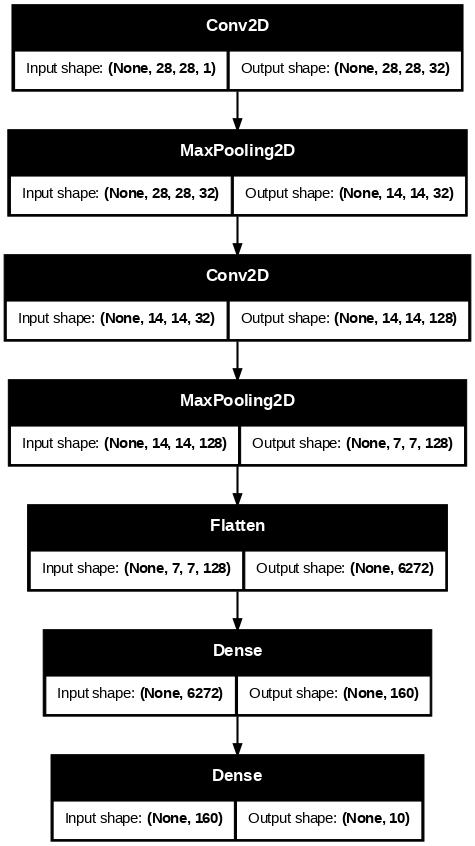

In [ ]:
tf.keras.utils.plot_model(best_model, show_shapes=True, dpi=75)

With that in mind, let's begin training a fresh model with these hyperparameters using the full number of epochs.

In [ ]:
new_model = dynamic_model().build(best_hps)

# Recompile the model with the best hyperparameters
optimizer_name = best_hps.get('optimizer')
optimizer = tf.keras.optimizers.get(optimizer_name)
new_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

# Use the best batch size found by the tuner
opt_batch_size = best_hps.get('batch_size')

history = new_model.fit(
    train_images,
    train_labels,
    epochs=EPOCHS,
    batch_size=opt_batch_size,
    validation_split = 0.2,
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7139 - auc: 0.9405 - loss: 0.9454 - precision: 0.8022 - recall: 0.6294 - val_accuracy: 0.8758 - val_auc: 0.9925 - val_loss: 0.3413 - val_precision: 0.8955 - val_recall: 0.8573
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8909 - auc: 0.9939 - loss: 0.2989 - precision: 0.9093 - recall: 0.8738 - val_accuracy: 0.8908 - val_auc: 0.9939 - val_loss: 0.3036 - val_precision: 0.9052 - val_recall: 0.8772
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9233 - auc: 0.9967 - loss: 0.2167 - precision: 0.9354 - recall: 0.9102 - val_accuracy: 0.8951 - val_auc: 0.9935 - val_loss: 0.2973 - val_precision: 0.9068 - val_recall: 0.8850
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9441 - auc: 0.9982 - loss: 0.1592 - precision: 0.9521 - recall: 0.9360 - val_accuracy: 0.9010 - val_auc: 0.9934 - val_loss: 0.2889 - val_precision: 0.9101 - val_recall: 0.8923
Epoch 5/10
250/250 ━━━━━━━━━━

It seems like the new model has similar performance to the last one. This indicates that the model's structure needs improvement, that the tuner config is weak, or that more tuning time was needed to find better hyperparameters.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


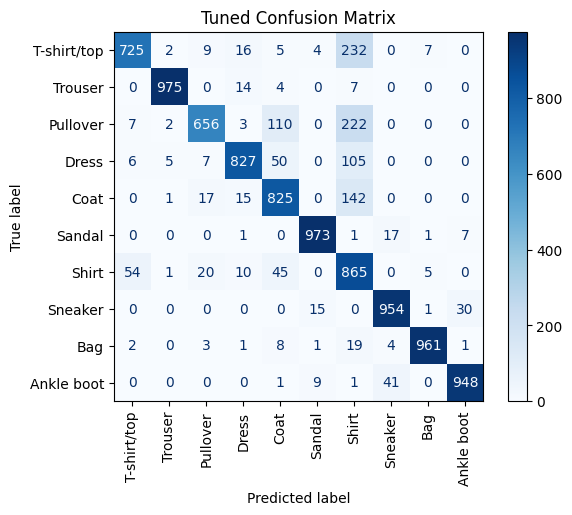

In [ ]:
# Predict the classes for the test set
y_pred = new_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=label_names)

# Remove the 'normalize' parameter and use 'include_values' instead to ensure compatibility
disp.plot(cmap=plt.cm.Blues)
plt.title("Tuned Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

The confusion matrix shows a similar story to the first one. Overall, the new model seems to have performed decently well, even if it's not a massive improvement over the original.